1. Is there something I can do now to start working on the presentation of my work. Not sure what kind of visuals/charts I can make with NLP analysis other than the word count graphs.
2. Do you have any suggestions on how I can structure my capstone better. 
3. I also have metadata on the movie reviews but I'm not sure how to use it.

count, distribution of length of reviews
distribution of review scores
By Genre
product category

Meta data, recommendation overlap with 'also bought column' 


# 2 Natural Language Processing Analysis

- Author: Jason Truong
- Last Modified: August 21, 2022
- Email: Jasontruong19@gmail.com

# Table of Contents

1. [Objective and Roadmap](#1Objective)  
2. [Preliminary Data Setup](#2Preliminary)  
    2.1. [Preprocessing: 'Overall'](#2_1Overall)  
    2.2. [Preprocessing: 'reviewScore'](#2_2Review)  
    2.3. [Preprocessing: 'Vote'](#2_3Vote)  
    2.4. [Drop duplicates and NaNs](#2_4Drop)  
3. [NLP Analysis Setup](#3NLP)  
4. [Test/Train Setup](#4Test_Train)  
5. [Logistic Regression](#5Logistic)  

# 1. Objective and Roadmap<a class ='anchor' id='1Objective'></a>

**Goal #1:** To predict the if the review has a positive or negative sentiment to it. This prediction is related to the prediction overall review score of the product.  
**Goal #2:** Predict if a review will have high or low votes from the community

NLP Roadmap:
1. Tokenize the review text
2. Remove the unnecessary tokens
3. Create a test train data split
4. See if Stemming and Lemmatization is needed
5. Create Models and Evaluate performance

# 2. Preliminary Data Setup<a class ='anchor' id='2Preliminary'></a>

In [30]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

Load in the dataset

In [2]:
review_data = []
with open('Movies_and_TV.json','r') as metafile:
    for x in range(50000):
        review_data.append(json.loads(next(metafile)))

Create the dataframe and explore the data

In [3]:
review_df = pd.DataFrame(review_data)

In [4]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         50000 non-null  float64
 1   verified        50000 non-null  bool   
 2   reviewTime      50000 non-null  object 
 3   reviewerID      50000 non-null  object 
 4   asin            50000 non-null  object 
 5   style           49624 non-null  object 
 6   reviewerName    49999 non-null  object 
 7   reviewText      49951 non-null  object 
 8   summary         49991 non-null  object 
 9   unixReviewTime  50000 non-null  int64  
 10  vote            9238 non-null   object 
 11  image           76 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 4.2+ MB


First step is to only focus on the sentiment of the review to try to predict the overall rating as well as the vote count so every other column will be dropped. A separate analysis will be done to include the summary text if time permits.

In [5]:
# Only keep the necessary columns
review_df = review_df[['overall', 'vote','reviewText','reviewerID','asin']]
review_df

,overall,vote,reviewText,reviewerID,asin
0,5.0,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665
1,5.0,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665
2,5.0,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665
3,5.0,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665
4,4.0,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665
...,...,...,...,...,...
49995,5.0,NaN,Very good move,A6DWOZHJAQMDI,0783225857
49996,5.0,NaN,"Thank you, Rick",A2WTMSH1OVB8GN,0783225857
49997,5.0,NaN,"Great classic film. If u didn't read the book,...",A3KDAC88FV2GMS,0783225857
49998,5.0,NaN,Gregory Pecks classic moving of the classic no...,A1H8C9ODLXR7HW,0783225857


In [6]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     50000 non-null  float64
 1   vote        9238 non-null   object 
 2   reviewText  49951 non-null  object 
 3   reviewerID  50000 non-null  object 
 4   asin        50000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


## 2.1. Check the datatype in the column `overall`<a class ='anchor' id='2_1Overall'></a> 

In [7]:
review_df['overall'].value_counts()

5.0    34556
4.0     7912
3.0     3334
1.0     2508
2.0     1690
Name: overall, dtype: int64

It looks like the values for the overall column are contained between 1 and 5 which makes sense since its a review out of 5. All of these are also integers so the datatype can be changed to a int8 type. This column represents the review score so it will be renamed for clarity.

In [8]:
review_df['overall'] = review_df['overall'].astype('int8')
review_df.rename(columns={'overall':'reviewScore'}, inplace = True)
review_df

,reviewScore,vote,reviewText,reviewerID,asin
0,5,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665
2,5,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665
3,5,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665
4,4,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665
...,...,...,...,...,...
49995,5,NaN,Very good move,A6DWOZHJAQMDI,0783225857
49996,5,NaN,"Thank you, Rick",A2WTMSH1OVB8GN,0783225857
49997,5,NaN,"Great classic film. If u didn't read the book,...",A3KDAC88FV2GMS,0783225857
49998,5,NaN,Gregory Pecks classic moving of the classic no...,A1H8C9ODLXR7HW,0783225857


## 2.2 Check the datatype in the column `reviewScore` <a class ='anchor' id='2_2Review'></a>

Split the reviewScore column to 'Good (value of 1)'  for reviews that are 4 or 5 and 'Bad (value of 0)' for reviews that are 1,2 or 3.

In [9]:
review_df['review_class'] = np.where(review_df['reviewScore']>=4,1,0)

In [10]:
review_df.head()

,reviewScore,vote,reviewText,reviewerID,asin,review_class
0,5,NaN,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665,1
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665,1
2,5,NaN,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665,1
3,5,NaN,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665,1
4,4,NaN,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665,1


This new `review_class` column will be used for the logistic regression with the sentiment from the `reviewText`

## 2.3 Check the datatype in the column `Vote`<a class ='anchor' id='2_3Vote'></a>

For the `vote` column, since the NaN values are essentially no votes with can be represented with 0, the NaN values will be replaced with a zero. There are also commas within the vote that causes problems when converted to an int so they will be removed.

In [11]:
review_df['vote'] = review_df['vote'].str.replace(r"\,","",regex = True)
review_df['vote'] = review_df['vote'].fillna(0)
review_df.head()

,reviewScore,vote,reviewText,reviewerID,asin,review_class
0,5,0,really happy they got evangelised .. spoiler a...,A3478QRKQDOPQ2,0001527665,1
1,5,3,Having lived in West New Guinea (Papua) during...,A2VHSG6TZHU1OB,0001527665,1
2,5,0,Excellent look into contextualizing the Gospel...,A23EJWOW1TLENE,0001527665,1
3,5,0,"More than anything, I've been challenged to fi...",A1KM9FNEJ8Q171,0001527665,1
4,4,0,This is a great movie for a missionary going i...,A38LY2SSHVHRYB,0001527665,1


In [12]:
review_df['vote'] = review_df['vote'].astype('int32')
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewScore   50000 non-null  int8  
 1   vote          50000 non-null  int32 
 2   reviewText    49951 non-null  object
 3   reviewerID    50000 non-null  object
 4   asin          50000 non-null  object
 5   review_class  50000 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 1.6+ MB


## 2.4 Drop any duplicates and NaNs in the dataframe <a class ='anchor' id='2_4Drop'></a>

The votes have now all been converted to numbers and the datatype can now be changed.

In [13]:
review_df.drop_duplicates(inplace = True, ignore_index = True)
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49948 entries, 0 to 49947
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewScore   49948 non-null  int8  
 1   vote          49948 non-null  int32 
 2   reviewText    49899 non-null  object
 3   reviewerID    49948 non-null  object
 4   asin          49948 non-null  object
 5   review_class  49948 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 1.6+ MB


1365 entries has been dropped.

### Remove any NaNs in the dataframe

Check the number of NaN values in the dataframe

In [14]:
review_df.isna().sum()

reviewScore      0
vote             0
reviewText      49
reviewerID       0
asin             0
review_class     0
dtype: int64

There seems to be 1497 NaN's in the `reviewText` column, since the NLP model is dependent on the `reviewText` those rows will be dropped.

In [15]:
review_df.dropna(inplace = True)
review_df.reset_index(drop=True, inplace= True)
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49899 entries, 0 to 49898
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewScore   49899 non-null  int8  
 1   vote          49899 non-null  int32 
 2   reviewText    49899 non-null  object
 3   reviewerID    49899 non-null  object
 4   asin          49899 non-null  object
 5   review_class  49899 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 1.6+ MB


The null values have been dropped since the dataframe now only contains 1997484 entries

# 3. Set up NLP analysis <a class ='anchor' id='3NLP'></a>

In [16]:
review_df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49899 entries, 0 to 49898
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewScore   49899 non-null  int8  
 1   vote          49899 non-null  int32 
 2   reviewText    49899 non-null  object
 3   reviewerID    49899 non-null  object
 4   asin          49899 non-null  object
 5   review_class  49899 non-null  int32 
dtypes: int32(2), int8(1), object(3)
memory usage: 1.6+ MB


## Convert the text in the reviewText column to vectors

In [17]:
# Instantiate 
review_wordbank = CountVectorizer()

# Fit the first 200000 reviews
review_wordbank.fit(review_df['reviewText'][:200000])

# 3. Transform
review_transformed = review_wordbank.transform(review_df['reviewText'][:200000])
review_transformed

<49899x52260 sparse matrix of type '<class 'numpy.int64'>'
	with 2058671 stored elements in Compressed Sparse Row format>

After preliminary vectorization with countvectorizer(), 200000 rows of reviews returned 106932 unique terms or tokens. Since this is unreasonable to load into memory.

Look at the first 10000 reviews to determine the approximate distribution of words

In [18]:
# Instantiate 
review_wordbank1 = CountVectorizer()

# Fit the first 10000 reviews
review_wordbank1.fit(review_df['reviewText'][:10000])

# 3. Transform
review_transformed1 = review_wordbank1.transform(review_df['reviewText'][:10000])
review_transformed1

<10000x21721 sparse matrix of type '<class 'numpy.int64'>'
	with 383999 stored elements in Compressed Sparse Row format>

In [19]:
review_transformed1.toarray().sum(axis=0)

array([14, 32,  1, ...,  1,  1,  1], dtype=int64)

In [20]:
prelim_df = pd.DataFrame(columns = review_wordbank1.get_feature_names(),data = review_transformed1.toarray())
display(prelim_df)

,00,000,000ft,001,007,00am,01qj6bc2sks,02,03,04,...,zombie,zondervan,zone,zoo,zoom,zorro,zowie,zsigmond,zuckerberg,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


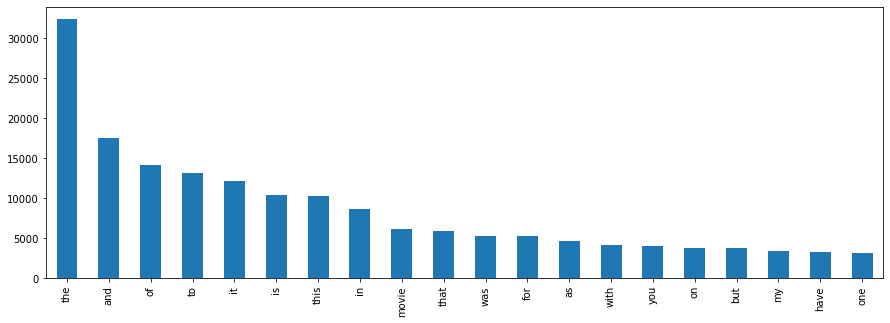

In [21]:
word_counts = pd.DataFrame({"counts":review_transformed1.toarray().sum(axis=0)},
                          index = review_wordbank1.get_feature_names()
                          ).sort_values("counts",ascending= False)

word_counts.head(20).plot(kind="bar",figsize=(15,5), legend = False)

plt.show()

By looking at the plot, the bulk of the words are stopwords which are not representative of the important words for the review text so they will be removed.

In [22]:
# Instantiate 
review_wordbank2= CountVectorizer(stop_words="english")

# Fit the first 200000 reviews
review_wordbank2.fit(review_df['reviewText'][:10000])

# 3. Transform
review_transformed2 = review_wordbank2.transform(review_df['reviewText'][:10000])
review_transformed2

<10000x21420 sparse matrix of type '<class 'numpy.int64'>'
	with 230456 stored elements in Compressed Sparse Row format>

301 tokens have been removed from the new model.

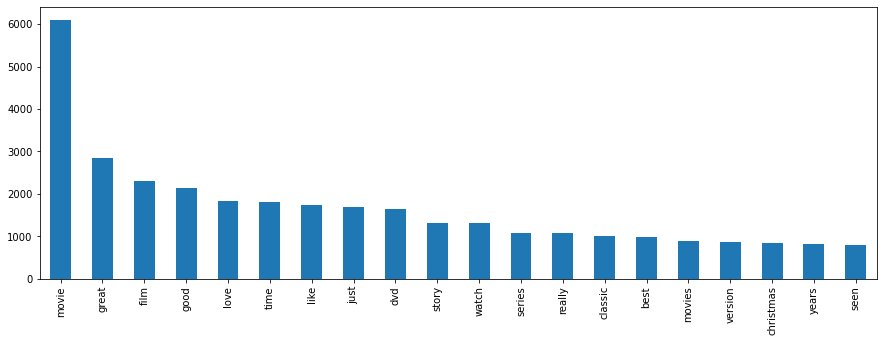

In [23]:
word_counts1 = pd.DataFrame({"counts":review_transformed2.toarray().sum(axis=0)},
                          index = review_wordbank2.get_feature_names()
                          ).sort_values("counts",ascending= False)

word_counts1.head(20).plot(kind="bar",figsize=(15,5), legend = False)

plt.show()

# 4. Set up Test/Train split <a class ='anchor' id='4Test_Train'></a>

Since the dataset is 2,000,000 rows, th

In [24]:
#Set up data for training and testing
X = review_df['reviewText']
y = review_df['review_class']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 2022)

Check the split of the data for the train and test set

In [25]:
y_train.value_counts()/y_train.shape[0]

1    0.849964
0    0.150036
Name: review_class, dtype: float64

The training data contains 82.2% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.2% chance of predicting the review sentiment correctly if every prediction made was positive.

In [26]:
y_test.value_counts()/y_test.shape[0]

1    0.847635
0    0.152365
Name: review_class, dtype: float64

The testing data contains 82.3% of positive reviews which means that the data is highly skewed towards positive reviews. There is a 82.2% chance of predicting the review sentiment correctly if every prediction made was positive.

# 5. Logistic Regression <a class ='anchor' id='5Logistic'></a>

In [31]:
# Instantiate 
review_wordbank3= CountVectorizer(stop_words="english")

# Fit the first 200000 reviews
review_wordbank3.fit(X_train)

# Transform
X_train_transformed = review_wordbank3.transform(X_train)
X_test_transformed = review_wordbank3.transform(X_test)

In [28]:
logreg = LogisticRegression(C = 0.1)
logreg.fit(X_train_transformed,y_train)

print(logreg.score(X_train_transformed,y_train))
print(logreg.score(X_test_transformed,y_test))

0.919059583632448
0.8896581040869618


In [29]:
#review_transformed.toarray().sum(axis=0)

array([ 80, 136,   1, ...,   1,   1,   1], dtype=int64)